In [1]:
import numpy as np
import os
import random
import torch
from configs.configs import Configs
from models.predictor_model import EssayScorer
from transformers import AutoConfig
from utils.create_embedding_feautres import create_embedding_features
from utils.dvrl_utils import get_sample_weight, fit_func, pred_func, calc_qwk

/Users/takumishibata/.pyenv/versions/3.11.5/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


load data from data/train_dev_test_split/1/fold-0/...
Loading embedding from cache...
load data from data/train_dev_test_split/2/fold-0/...
Loading embedding from cache...
X_train:  (2151, 1024)
Y_train:  (2151,)
Y_train max:  1.0
Y_train min:  0.0
X_dev:  (356, 1024)
Y_dev:  (356,)
Y_dev max:  1.0
Y_dev min:  0.1
X_test:  (356, 1024)
Y_test:  (356,)
Y_test max:  1.0
Y_test min:  0.0
Creating predictor model...
QWK: 0.4998
Creating predictor model...
QWK: 0.7313
Creating predictor model...
QWK: 0.6766
Creating predictor model...
QWK: 0.7215
Creating predictor model...
QWK: 0.7524
Creating predictor model...
QWK: 0.7439
Creating predictor model...
QWK: 0.7864
Creating predictor model...
QWK: 0.7755
Creating predictor model...
QWK: 0.7736
Creating predictor model...
QWK: 0.7623
Creating predictor model...
QWK: 0.7707
Creating predictor model...
QWK: 0.7944
Creating predictor model...
QWK: 0.7701
Creating predictor model...
QWK: 0.7885
Creating predictor model...
QWK: 0.7925
Creating pred

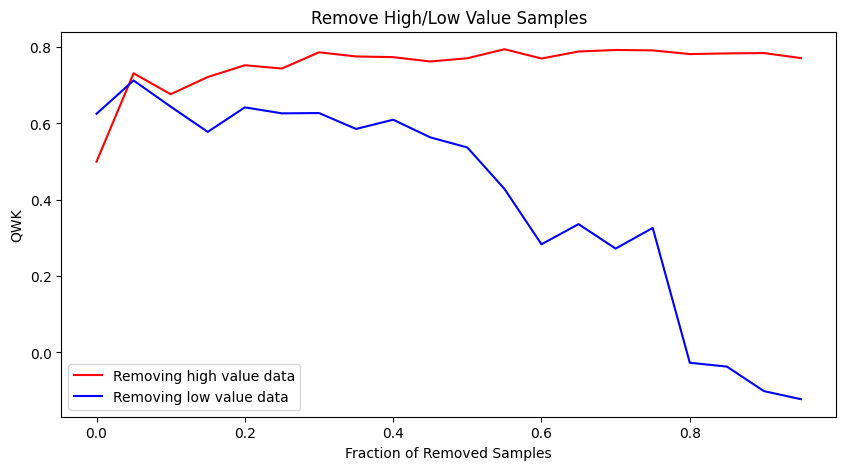

In [2]:
seed = 12
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_prompt_id = 1
configs = Configs()
attribute_name = 'score'

# Load data
noise_prompt = 2
data_path1 = configs.DATA_PATH2 + str(test_prompt_id) + '/fold-0/'
data_path2 = configs.DATA_PATH2 + str(noise_prompt) + '/fold-0/'
model_name = 'microsoft/deberta-v3-large'

train_features1, dev_features1, test_features1, y_train1, y_dev1, y_test1 = create_embedding_features(data_path1, test_prompt_id, attribute_name, model_name, device)
train_features2, dev_features2, test_features2, y_train2, y_dev2, y_test2 = create_embedding_features(data_path2, noise_prompt, attribute_name, model_name, device)

# Concatenate data of prompt 1 and prompt 2
train_features = np.concatenate([train_features1, train_features2], axis=0)
y_train = np.concatenate([y_train1, y_train2[::-1]], axis=0)

# print info
print('================================')
print('X_train: ', train_features.shape)
print('Y_train: ', y_train.shape)
print('Y_train max: ', np.max(y_train))
print('Y_train min: ', np.min(y_train))

print('================================')
print('X_dev: ', dev_features1.shape)
print('Y_dev: ', y_dev1.shape)
print('Y_dev max: ', np.max(y_dev1))
print('Y_dev min: ', np.min(y_dev1))

print('================================')
print('X_test: ', test_features1.shape)
print('Y_test: ', y_test1.shape)
print('Y_test max: ', np.max(y_test1))
print('Y_test min: ', np.min(y_test1))
print('================================')

# Remove high and low value samples
high_qwks = []
for p in np.arange(0.0, 1.0, 0.05):
    # Create predictor
    print('Creating predictor model...')
    config = AutoConfig.from_pretrained(model_name)
    pred_model = EssayScorer(config.hidden_size)

    weights = get_sample_weight(np.load('estimated_data_value_sample.npy'), top_p=p, ascending=True)
    history = fit_func(pred_model, train_features, y_train, batch_size=256, epochs=100, device=device, sample_weight=weights)

    y_pred = pred_func(pred_model, dev_features1, batch_size=256, device=device)
    qwk = calc_qwk(y_dev1, y_pred, test_prompt_id, 'score')
    print(f'QWK: {qwk:.4f}')
    high_qwks.append(qwk)

low_qwks = []
for p in np.arange(0.0, 1.0, 0.05):
    # Create predictor
    print('Creating predictor model...')
    config = AutoConfig.from_pretrained(model_name)
    pred_model = EssayScorer(config.hidden_size)


    weights = get_sample_weight(np.load('estimated_data_value_sample.npy'), top_p=p, ascending=False)
    history = fit_func(pred_model, train_features, y_train, batch_size=256, epochs=100, device=device, sample_weight=weights)

    y_pred = pred_func(pred_model, dev_features1, batch_size=256, device=device)
    qwk = calc_qwk(y_dev1, y_pred, test_prompt_id, 'score')
    print(f'QWK: {qwk:.4f}')
    low_qwks.append(qwk)

import matplotlib.pyplot as plt
# plot loss
p = np.arange(0.0, 1.0, 0.05)
plt.figure(figsize=(10, 5))
plt.plot(p, high_qwks, label='Removing high value data', color='red')
plt.plot(p, low_qwks, label='Removing low value data', color='blue')
plt.title('Remove High/Low Value Samples')
plt.xlabel('Fraction of Removed Samples')
plt.ylabel('QWK')
plt.legend()
plt.show()